In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models.scrambler_models_w_diff import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores


Using TensorFlow backend.


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 77#80
proximal_end = 127#80 + 30


In [3]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

#Re-define model for variant lor prediction
ref_input = Input(name="ref_input", shape=(1, 205, 4))
var_input = Input(name="var_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))

ref_cut = aparent_model([ref_input, l_input])[1]
var_cut = aparent_model([var_input, l_input])[1]

def _lor(inp, iso_start=proximal_start, iso_end=proximal_end) :

    cuts_ref, cuts_var = inp
    
    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_var = K.sum(cuts_var[:, iso_start:iso_end], axis=-1)[:, None]
    
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    y_var = K.clip(y_var, K.epsilon(), 1.0 - K.epsilon())

    lor = K.log(y_var / (1. - y_var)) - K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')([ref_cut, var_cut])

predictor = Model(
    inputs=[ref_input, var_input, l_input],
    outputs=[lor_pred]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Load CSE variant data

data_df = pd.read_csv("apa_cse_variant_data_filtered.csv", sep='\t')

data_df = data_df.query("delta_cse_score < -2. and delta_logodds_true > -2. and delta_logodds_pred > -2.")

data_df = data_df.loc[~data_df['cse_var'].isin(["ATAAAA", "AATTAA"])]

data_df = data_df.sort_values(by='delta_logodds_pred', ascending=False)

data_df = data_df.drop_duplicates(subset=['gene'], keep='first').copy().reset_index(drop=True)

data_df['wt_seq'] = "ACACGACGCTCTTCCGATCT" + data_df['wt_seq'] + "GGAGCAGATACTGGCTTAACT"
data_df['master_seq'] = "ACACGACGCTCTTCCGATCT" + data_df['master_seq'] + "GGAGCAGATACTGGCTTAACT"

data_df['cse_ref_ext'] = data_df['wt_seq'].str.slice(70-3, 76+3)
data_df['cse_ref_var'] = data_df['master_seq'].str.slice(70-3, 76+3)

print("len(data_df) = " + str(len(data_df)))


len(data_df) = 24


In [5]:

data_df[['gene', 'cse_ref', 'cse_var', 'delta_logodds_true', 'delta_logodds_pred', 'delta_cse_score', 'cse_ref_ext', 'cse_ref_var']]


,gene,cse_ref,cse_var,delta_logodds_true,delta_logodds_pred,delta_cse_score,cse_ref_ext,cse_ref_var
0,HBB.1,AATAAA,AATAAT,-0.494938,-0.198359,-3.511939,CCTAATAAAAAA,CCTAATAATAAA
1,PTEN.16,AATAAA,AATAAT,-0.390764,-0.203988,-3.511939,TTGAATAAACTG,TTGAATAATCTG
2,SMAD4.2,AATAAA,AACAAA,-0.405876,-0.249485,-4.365897,ATAAATAAAGGA,ATAAACAAAGGA
3,PMP22.1,AATAAA,AACAAA,-1.111759,-0.658694,-4.365897,TAAAATAAACAT,TAAAACAAACAT
4,COL3A1.2,AATAAA,AATACA,-0.983458,-0.694853,-3.392429,ATAAATAAACTT,ATAAATACACTT
5,TPMT.6,ATTAAA,ATGAAA,-0.007226,-0.732651,-2.911806,ACAATTAAAAAA,ACAATGAAAAAA
6,SMAD4.9,AATAAA,AATAAT,-1.401327,-0.818128,-3.511939,AGGAATAAAGGT,AGGAATAATGGT
7,SDHAF2.1,ATTAAA,TTTAAA,-1.724318,-0.825827,-2.946632,ATTATTAAAGCA,ATTTTTAAAGCA
8,TSC2.1,AATAAA,AATACA,-1.573708,-0.826940,-3.392429,ATAAATAAAGTC,ATAAATACAGTC
9,PTEN.12,ATTAAA,GTTAAA,-0.209445,-0.905223,-3.050597,CTCATTAAATAT,CTCGTTAAATAT


In [6]:
#Generate training and test set indexes

#Load data matrices
encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_ref_sel = np.concatenate([encoder(row['wt_seq'])[None, None, ...] for _, row in data_df.iterrows()], axis=0)
x_var_sel = np.concatenate([encoder(row['master_seq'])[None, None, ...] for _, row in data_df.iterrows()], axis=0)

l_sel = np.zeros((x_ref_sel.shape[0], 13))
l_sel[:, 11] = 1.

y_true_sel = np.reshape(data_df['delta_logodds_true'], (len(data_df), 1))
y_pred_sel = np.reshape(data_df['delta_logodds_pred'], (len(data_df), 1))

print("x_ref_sel.shape = " + str(x_ref_sel.shape))
print("x_ref_sel.shape = " + str(x_ref_sel.shape))
print("l_sel.shape = " + str(l_sel.shape))
print("y_true_sel.shape = " + str(y_true_sel.shape))

#Overwrite with new resnet lor predictions

y_pred_sel = predictor.predict(x=[x_ref_sel, x_var_sel, l_sel], batch_size=32, verbose=True)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


x_ref_sel.shape = (24, 1, 205, 4)
x_ref_sel.shape = (24, 1, 205, 4)
l_sel.shape = (24, 13)
y_true_sel.shape = (24, 1)
24/24 [==============================] - 7s 284ms/step


In [7]:
#Define sequence template and background

sequence_template = 'ACACGACGCTCTTCCGATCT$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$GGAGCAGATACTGGCTTAACT'

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = np.zeros((205, 4))

#Set uniform background
x_mean[:, :] = 0.25


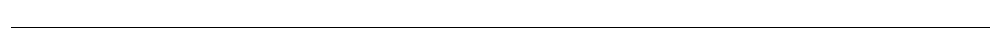

In [8]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [9]:
#Calculate biased, example-specific backgrounds

pseudo_count = 1.0

x_mean_sel = (x_ref_sel[:, 0, ...] + pseudo_count) / (1. + 4. * pseudo_count)

#Lock background across CSE
x_mean_sel[:, 70:76, :] = np.clip(x_ref_sel[:, 0, 70:76, :], 1e-7, 1. - 1e-7)

group_sel = np.arange(x_mean_sel.shape[0])[:, None]


In [10]:
#Run optimization with bias turned on across CSE, to reduce variance further

cse_bias = np.zeros((1, 1, 205, 1))
cse_bias[:, :, 70:76, :] = 50.


In [43]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template for k in range(x_ref_sel.shape[0])],
    input_backgrounds=[x_mean_sel[k, :, :] for k in range(x_ref_sel.shape[0])],
    batch_size=1,
    n_samples=128,
    multi_input_mode='shared',
    sample_mode='gumbel',
    gumbel_temp=0.1,
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config,
    subset_size=None
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [44]:
#Round 1: Pre-training

[pwm_ref_sel_pre, pwm_var_sel_pre], [sample_ref_sel_pre, sample_var_sel_pre], [scores_sel_pre, _], pretrain_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    np.zeros((x_ref_sel.shape[0], 1)),
    bias=[np.tile(cse_bias, (x_ref_sel.shape[0], 1, 1, 1))],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=100,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.25,
    entropy_weight=1.,
    subset_size=None,
    cache_prefix_path='saved_models/apa_cse_vars',
    load_from_cache=False,
)

#Round 2: Fine-tuning

[pwm_ref_sel_fine, pwm_var_sel_fine], [sample_ref_sel_fine, sample_var_sel_fine], [scores_sel_fine, _], finetune_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    y_true_sel,
    bias=[np.tile(cse_bias, (x_ref_sel.shape[0], 1, 1, 1))],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=300,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.0,
    entropy_weight=1.0,
    subset_size=None,
    cache_prefix_path='saved_models/apa_cse_vars',
    load_from_cache=True,
)


Optimizing batch 0...
Epoch 1/1
100/100 [==============================] - 24s 238ms/step - loss: 0.1335 - ft_nll_loss: 0.1104 - ft_entropy_loss: 0.0232
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.5691 - ft_nll_loss: 0.5049 - ft_entropy_loss: 0.0642
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.5732 - ft_nll_loss: 0.5206 - ft_entropy_loss: 0.0526
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.5023 - ft_nll_loss: 0.4554 - ft_entropy_loss: 0.0469
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.2503 - ft_nll_loss: 0.2162 - ft_entropy_loss: 0.0340
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.2061 - ft_nll_loss: 0.1632 - ft_entropy_loss: 0.0429
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.5350 - ft_nll_loss: 0.4726 - ft_entropy_loss: 0.0624
Epoch 1/1
100/100 [==============================] - 12s 116m

In [11]:
#Cache interpretations

save_suffix = '_per_example_no_drop_inference_mode_cse_vars'
'''
#Store interpretations
pickle.dump({
    'pwm_ref_sel_pre' : pwm_ref_sel_pre,
    'pwm_var_sel_pre' : pwm_var_sel_pre,

    'sample_ref_sel_pre' : sample_ref_sel_pre,
    'sample_var_sel_pre' : sample_var_sel_pre,

    'scores_sel_pre' : scores_sel_pre,
    
    'pwm_ref_sel_fine' : pwm_ref_sel_fine,
    'pwm_var_sel_fine' : pwm_var_sel_fine,

    'sample_ref_sel_fine' : sample_ref_sel_fine,
    'sample_var_sel_fine' : sample_var_sel_fine,

    'scores_sel_fine' : scores_sel_fine,
}, open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'wb'))
'''

#Load interpretations
cache_dict = pickle.load(open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'rb'))

pwm_ref_sel_pre = cache_dict['pwm_ref_sel_pre']
pwm_var_sel_pre = cache_dict['pwm_var_sel_pre']

sample_ref_sel_pre = cache_dict['sample_ref_sel_pre']
sample_var_sel_pre = cache_dict['sample_var_sel_pre']

scores_sel_pre = cache_dict['scores_sel_pre']

pwm_ref_sel_fine = cache_dict['pwm_ref_sel_fine']
pwm_var_sel_fine = cache_dict['pwm_var_sel_fine']

sample_ref_sel_fine = cache_dict['sample_ref_sel_fine']
sample_var_sel_fine = cache_dict['sample_var_sel_fine']

scores_sel_fine = cache_dict['scores_sel_fine']


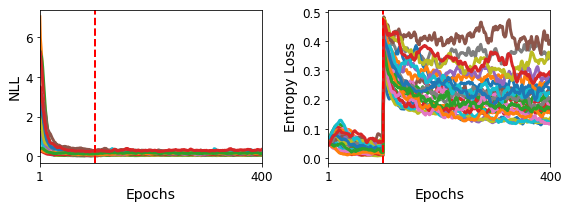

In [46]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(pretrain_histories[0]['ft_nll']) + len(finetune_histories[0]['ft_nll'])

n_epochs_pretrain = len(pretrain_histories[0]['ft_nll'])
n_epochs_finetune = len(finetune_histories[0]['ft_nll'])

nll_rolling_window = 5
entropy_rolling_window = 1

for i in range(len(pretrain_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_nll']), np.array(finetune_histories[i]['ft_nll'])], axis=0), window=nll_rolling_window), linewidth=3)

ax1.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(pretrain_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_entropy']), np.array(finetune_histories[i]['ft_entropy'])], axis=0), window=entropy_rolling_window), linewidth=3)

ax2.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [13]:
#Mask out USE and DSE regions (do not consider CSE)
sequence_mask_no_cse = np.copy(sequence_mask)
sequence_mask_no_cse[70:76] = 0.

#Subtract biases
scores_sel_fine = scores_sel_fine - cse_bias

scores_sel_fine *= sequence_mask_no_cse[None, None, :, None]

#Normalize to max score = 1
scores_sel_fine /= np.max(scores_sel_fine, axis=(1, 2, 3), keepdims=True)


In [14]:
#Cache scores
save_name = 'apa_vars_cse_resnet_mpra_scrambler_shared'

np.save(save_name + '_ref_scores', scores_sel_fine)
np.save(save_name + '_var_scores', scores_sel_fine)
np.save(save_name + '_scores', scores_sel_fine)

#Load scores

scores_sel_fine = np.load(save_name + '_scores.npy')


Sequence 0:
PAS ID HBB.1:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = -0.215
 - Prediction (scrambled) = -0.165
 - Measured = -0.494
 - CSE Score (ref) = 3.9180
 - CSE Score (var) = 0.4061
 - CSE Score (delta) = -3.511


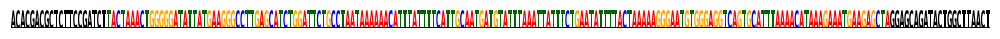

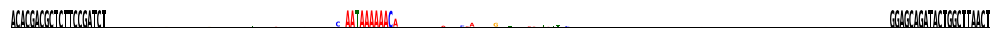

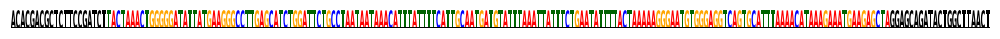

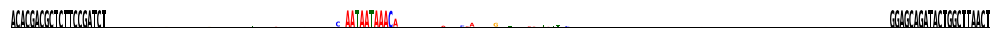

Net Scores:


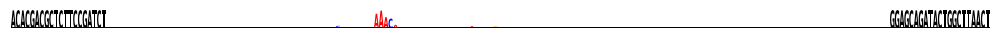

Sequence 1:
PAS ID PTEN.16:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = -0.315
 - Prediction (scrambled) = -0.311
 - Measured = -0.390
 - CSE Score (ref) = 3.9180
 - CSE Score (var) = 0.4061
 - CSE Score (delta) = -3.511


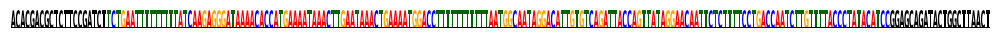

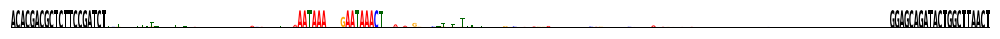

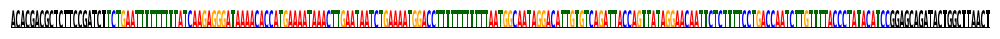

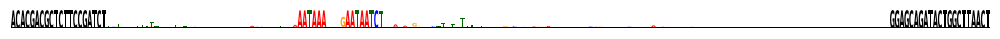

Net Scores:


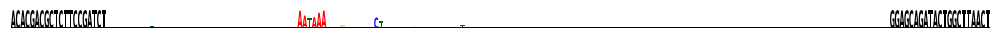

Sequence 5:
PAS ID TPMT.6:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = 0.0726
 - Prediction (scrambled) = -0.053
 - Measured = -0.007
 - CSE Score (ref) = 2.7471
 - CSE Score (var) = -0.164
 - CSE Score (delta) = -2.911


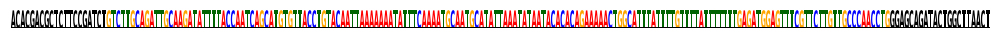

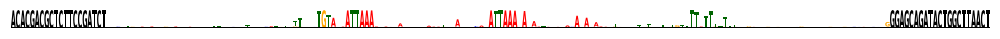

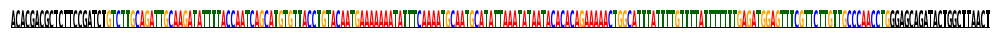

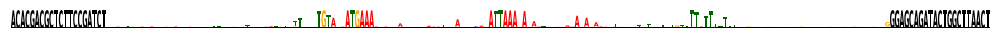

Net Scores:


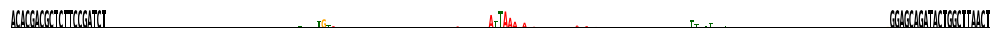

Sequence 11:
PAS ID SMAD4.1:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = -0.863
 - Prediction (scrambled) = -0.857
 - Measured = -1.097
 - CSE Score (ref) = 2.7471
 - CSE Score (var) = -0.085
 - CSE Score (delta) = -2.832


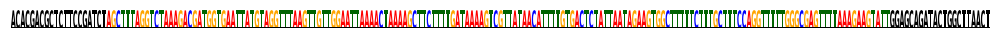

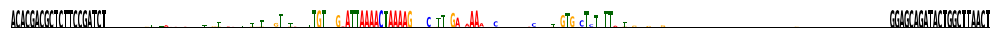

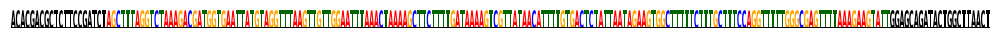

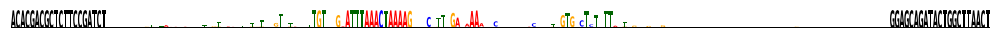

Net Scores:


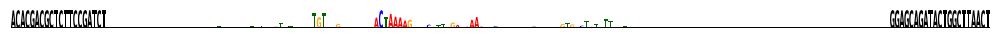

Sequence 13:
PAS ID LAMC2.1:
ClinVar ID NM_005562.2(LAMC2):c.*1482A>G:
Significance Undetermined:
 - Prediction (original) = -1.355
 - Prediction (scrambled) = -1.446
 - Measured = -1.967
 - CSE Score (ref) = 3.9180
 - CSE Score (var) = 1.5847
 - CSE Score (delta) = -2.333


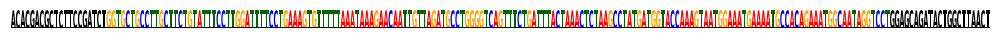

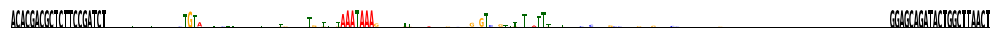

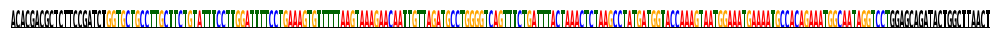

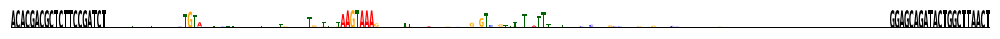

Net Scores:


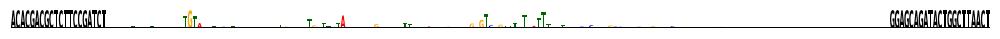

Sequence 21:
PAS ID BRCA2.1:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = -1.826
 - Prediction (scrambled) = -1.803
 - Measured = -1.520
 - CSE Score (ref) = 3.9180
 - CSE Score (var) = 1.5847
 - CSE Score (delta) = -2.333


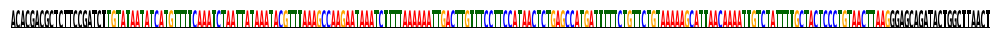

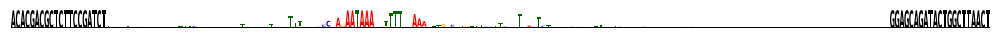

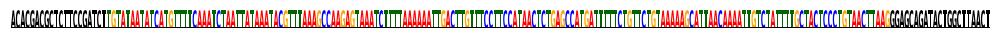

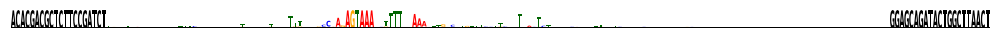

Net Scores:


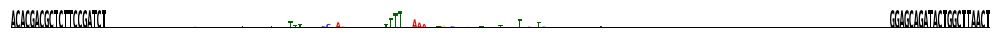

In [16]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_resnet_mpra_scrambler_shared_cse_vars"

plot_examples = [0, 1, 5, 11, 13, 21]
save_examples = []#[0, 1, 5, 11, 13, 21]

q_thresh = 1.0#0.95

for plot_i in range(x_ref_sel.shape[0]) :
    
    if plot_i not in plot_examples :
        continue
    
    print("Sequence " + str(plot_i) + ":")
    print("PAS ID " + data_df.iloc[plot_i]['gene'] + ":")
    print("ClinVar ID " + data_df.iloc[plot_i]['clinvar_id'] + ":")
    print("Significance " + data_df.iloc[plot_i]['significance'] + ":")
    
    lor_sel = predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_sel_fine = np.mean(predictor.predict(x=[sample_ref_sel_fine[plot_i], sample_var_sel_fine[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_fine.shape[1], 1))], batch_size=32)[:, 0])
    
    print(" - Prediction (original) = " + str(round(lor_sel, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_sel_fine, 6))[:6])
    
    print(" - Measured = " + str(round(data_df.iloc[plot_i]['delta_logodds_true'], 6))[:6])
    
    print(" - CSE Score (ref) = " + str(round(data_df.iloc[plot_i]['cse_ref_score'], 6))[:6])
    print(" - CSE Score (var) = " + str(round(data_df.iloc[plot_i]['cse_var_score'], 6))[:6])
    print(" - CSE Score (delta) = " + str(round(data_df.iloc[plot_i]['delta_cse_score'], 6))[:6])
    
    save_figs = False
    if save_examples is not None and plot_i in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_sel_fine[plot_i, 0, :, :], q=q_thresh)
    
    plot_dna_logo(x_ref_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref")
    plot_dna_logo(pwm_ref_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref" + "_pwm")
    
    plot_dna_logo(x_var_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var")
    plot_dna_logo(pwm_var_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var" + "_pwm")
    
    print("Net Scores:")
    plot_dna_importance_scores(scores_sel_fine[plot_i, 0, :, :].T, encoder.decode(x_ref_sel[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_scores")
    